# Spaceship Titanic Scratchpad

This notebook is my (Spencer Lyon) scratch pad that I used when working on the spaceship titanic kaggle compeition. 

It is very much a "stream of conciousness" style where I repeat the cycle (1) write out what I want to do (2) implement the code (3) react to the output and (4) make a modified plan. While I don't necessarily recommend that anyone go there, reading from top to bottom should provide a glimpse into my thought process and how I approach solving ML tasks.

In [3]:
import tensorflow as tf
# tf.config.list_physical_devices('GPU')

In [1]:
# %pip install missingno

In [2]:
%run setup_mlflow.py
mlflow.autolog()

good work! mlflow ready to go


In [3]:
import pandas as pd

In [4]:
raw = pd.read_csv("train.csv", index_col="PassengerId")
raw.info()
raw.head()

<class 'pandas.core.frame.DataFrame'>
Index: 8693 entries, 0001_01 to 9280_02
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    8492 non-null   object 
 1   CryoSleep     8476 non-null   object 
 2   Cabin         8494 non-null   object 
 3   Destination   8511 non-null   object 
 4   Age           8514 non-null   float64
 5   VIP           8490 non-null   object 
 6   RoomService   8512 non-null   float64
 7   FoodCourt     8510 non-null   float64
 8   ShoppingMall  8485 non-null   float64
 9   Spa           8510 non-null   float64
 10  VRDeck        8505 non-null   float64
 11  Name          8493 non-null   object 
 12  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(6)
memory usage: 891.4+ KB


,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
PassengerId,,,,,,,,,,,,,
0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


## Initial cleanups

We need to do two things initialy:

1. Make `VIP` and `CryoSleep` actual bools
2. Split the `Cabin` column

From the competition description we read that the Cabin variable is actually three categoricals in one:

- Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.

Let's split that column on the `/`

In [5]:
def initial_prep(df):
    out = df.copy()
    out[["VIP", "CryoSleep"]] = out[["VIP", "CryoSleep"]].astype(bool)
    
    new_cols = (
        out["Cabin"]
        .str.split("/", expand=True)
        .set_axis(["deck", "num", "side"], axis=1)
    )
    out = pd.concat([
        out.copy().drop(["Cabin"], axis=1),
        new_cols
    ], axis=1)
    out["num"] = out["num"].astype(float)
    return out

In [6]:
df = initial_prep(raw)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 8693 entries, 0001_01 to 9280_02
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    8492 non-null   object 
 1   CryoSleep     8693 non-null   bool   
 2   Destination   8511 non-null   object 
 3   Age           8514 non-null   float64
 4   VIP           8693 non-null   bool   
 5   RoomService   8512 non-null   float64
 6   FoodCourt     8510 non-null   float64
 7   ShoppingMall  8485 non-null   float64
 8   Spa           8510 non-null   float64
 9   VRDeck        8505 non-null   float64
 10  Name          8493 non-null   object 
 11  Transported   8693 non-null   bool   
 12  deck          8494 non-null   object 
 13  num           8494 non-null   float64
 14  side          8494 non-null   object 
dtypes: bool(3), float64(7), object(5)
memory usage: 908.4+ KB


,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,deck,num,side
PassengerId,,,,,,,,,,,,,,,
0001_01,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,B,0.0,P
0002_01,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,F,0.0,S
0003_01,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,A,0.0,S
0003_02,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,A,0.0,S
0004_01,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,F,1.0,S


## Missing Data

One of the biggest hurdles we have to jump is dealing with missing data

As you can see below, there is a lot of it

<AxesSubplot: >

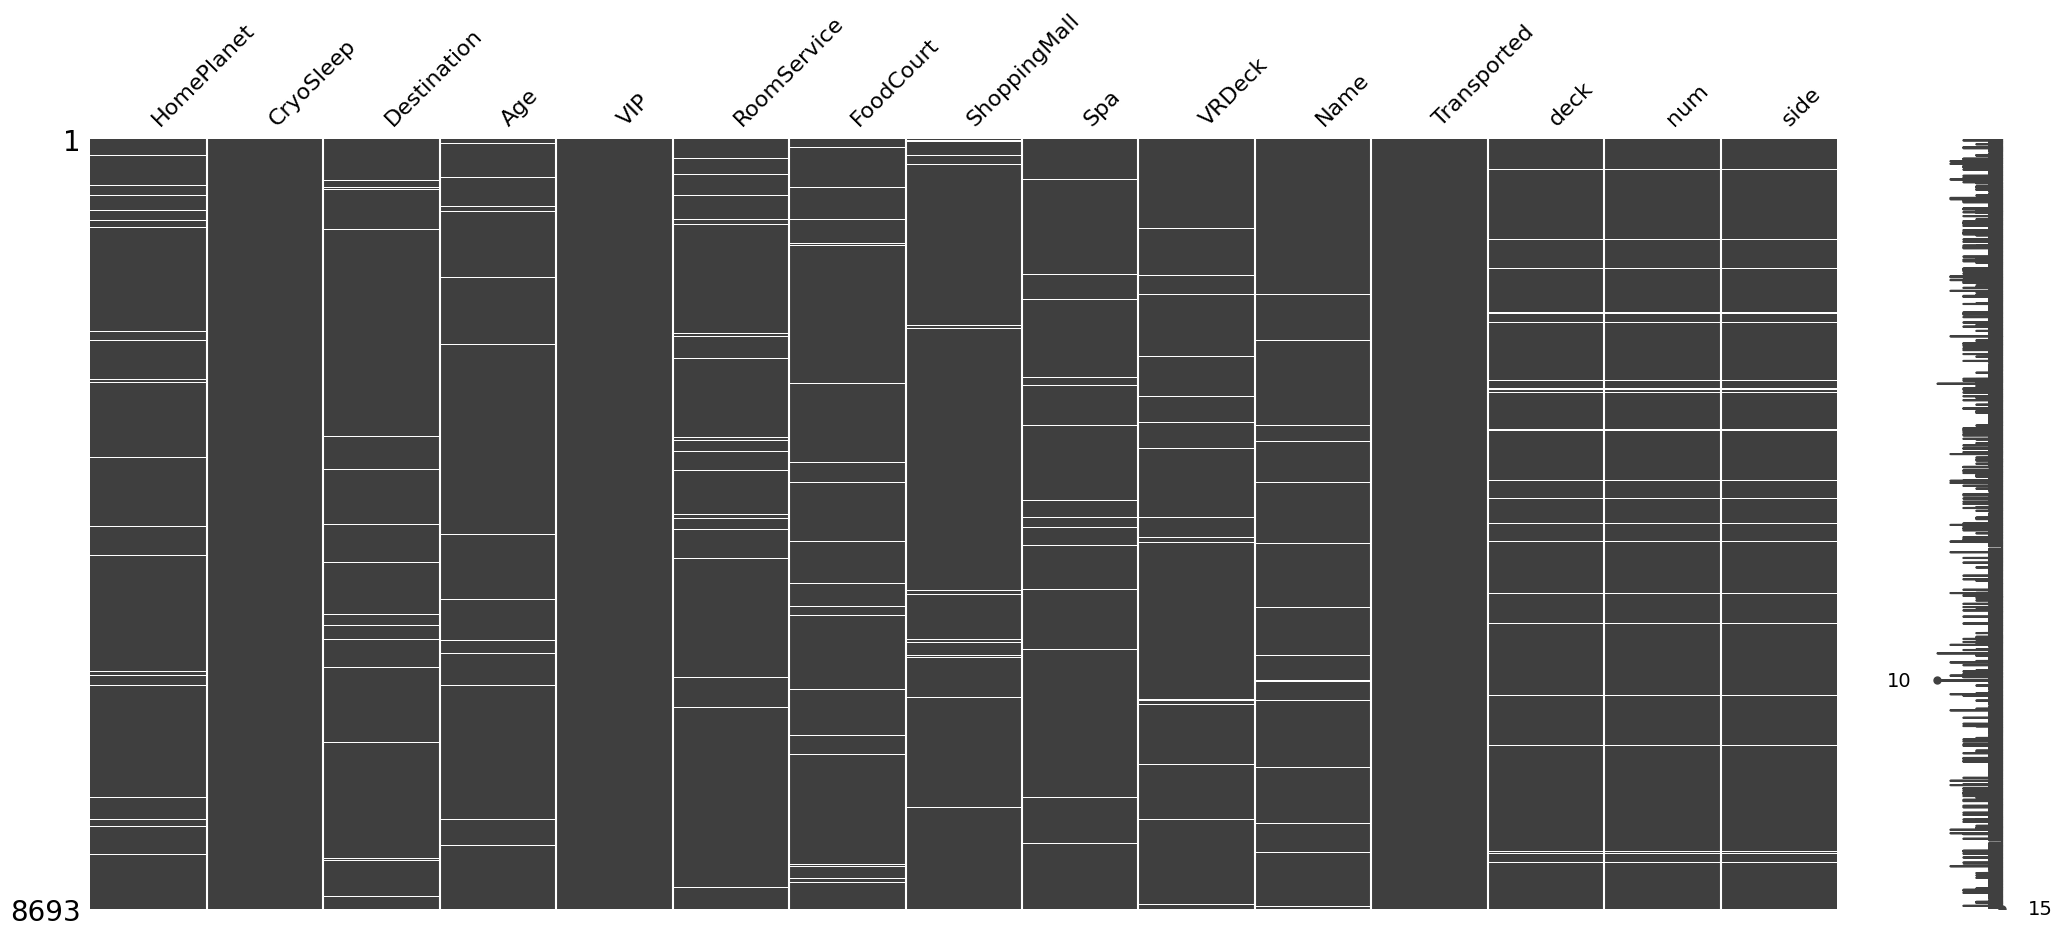

In [7]:
import missingno as msno
%matplotlib inline
msno.matrix(df)

One very common approach is to fill misisng data with the most likely value

For numeric variables this would arguably be the median

For categorical variables, this would be the mode

We can use tools from sklearn to do this

In [8]:
from sklearn import compose, impute, pipeline

2022/11/18 17:36:48 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of sklearn. If you encounter errors during autologging, try upgrading / downgrading sklearn to a supported version, or try upgrading MLflow.
2022/11/18 17:36:48 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.


In [9]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 8693 entries, 0001_01 to 9280_02
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    8492 non-null   object 
 1   CryoSleep     8693 non-null   bool   
 2   Destination   8511 non-null   object 
 3   Age           8514 non-null   float64
 4   VIP           8693 non-null   bool   
 5   RoomService   8512 non-null   float64
 6   FoodCourt     8510 non-null   float64
 7   ShoppingMall  8485 non-null   float64
 8   Spa           8510 non-null   float64
 9   VRDeck        8505 non-null   float64
 10  Name          8493 non-null   object 
 11  Transported   8693 non-null   bool   
 12  deck          8494 non-null   object 
 13  num           8494 non-null   float64
 14  side          8494 non-null   object 
dtypes: bool(3), float64(7), object(5)
memory usage: 908.4+ KB


,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,deck,num,side
PassengerId,,,,,,,,,,,,,,,
0001_01,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,B,0.0,P
0002_01,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,F,0.0,S
0003_01,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,A,0.0,S
0003_02,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,A,0.0,S
0004_01,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,F,1.0,S


In [10]:
categorical_cols = ["HomePlanet", "Destination", "deck", "side"]
bool_cols = ["CryoSleep", "VIP"]
numeric_cols = ["Age", "RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck", "num"]

feature_cols = categorical_cols + bool_cols + numeric_cols
target_col = "Transported"

Later on we will use a [ColumnTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html#sklearn.compose.ColumnTransformer) to transform each column

This will allow us to apply different sets of preprocessing steps to groups of columns

We'll start by defining how we want to handle missing data:

In [11]:
cat_missing =  impute.SimpleImputer(strategy="most_frequent")

# NOTE: needs to be a function so we can use this same strategy more than once
#       you'll see below...
numeric_missing = lambda: impute.SimpleImputer(strategy="median")

## Feature engineering

The next step is to do some feature engineering

### Categorical Features

Let's start by looking at the cardinality of our categorical variables

In [12]:
df[categorical_cols].nunique()

HomePlanet     3
Destination    3
deck           8
side           2
dtype: int64

These all look look small enough in cardinality to apply one-hot encoding across the board

In [13]:
from sklearn import preprocessing

# now let's make a pipeline that will apply the missing data strategy and then one-hot encoding
cat_pipeline = pipeline.make_pipeline(
    cat_missing,
    preprocessing.OneHotEncoder()
)

That takes care of our categorical features

### Continuous Features

Now let's look at our continuous features

In [14]:
df[numeric_cols].describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,num
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000,8494.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791,600.367671
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189,511.867226
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,167.250000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,427.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000,999.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000,1894.000000


All these columns except `Age` and `num` represent spending

For these we can do a "StandardScaler" to have them be mean 0, variance 1

Let's split the age column into 5 bins using `KBinsDiscretizer` (reasoning: actual age likely doesn't matter, but "relative age" might. Bins let's us keep some of the variation in age, but without treating it fully continuously)

Finally, let's do a MinMax scaler for the num (reasoning: room number might not matter much, we'll just normalize the data so it lives between 0 and 1 so as to not mess up our estimators -- some estimators behave very poorly when features live on different scales)

In [15]:
spend_cols = ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]
spend_pipeline = pipeline.make_pipeline(
    numeric_missing(),
    preprocessing.StandardScaler()
)

age_pipeline = pipeline.make_pipeline(
    numeric_missing(),
    preprocessing.KBinsDiscretizer(n_bins=5)
)


num_pipeline = num_pipeline = pipeline.make_pipeline(
    numeric_missing(),
    preprocessing.MinMaxScaler()
)

We can now combine all these steps into a column transformer

In [16]:
process = compose.ColumnTransformer([
    ("cat", cat_pipeline, categorical_cols),
    ("num", num_pipeline, ["num"]),
    ("spend_scaler", spend_pipeline, spend_cols),
    ("age", age_pipeline, ["Age"]),
    ("bools", "passthrough", ["VIP", "CryoSleep"])
])

process # visualize the processing steps

ColumnTransformer(transformers=[('cat',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder())]),
                                 ['HomePlanet', 'Destination', 'deck', 'side']),
                                ('num',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('minmaxscaler',
                                                  MinMaxScaler())]),
                                 ['num']),
                                ('spend_scaler',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['RoomService', 'FoodCourt', 'ShoppingMall',
                                  'Spa', 'VRDeck']),
                                ('age',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('kbinsdiscretizer',
                                                  KBinsDiscretizer())]),
                                 ['Age']),
                                ('bools', 'passthrough', ['VIP', 'CryoSleep'])])

## Split dataset

Now that we have a plan for dealing with the missing data and engineering features, we will split the data into training and testing subsets before applying our transforms.

In [17]:
from sklearn import model_selection

df2 = df.copy()
y_raw = df2.pop("Transported")

X0_train, X0_test, y_train, y_test = model_selection.train_test_split(df2, y_raw, test_size=0.3)

## Modeling

Now we are ready to try out some models

Let's start out as simple as possible... Logistic regression

In [18]:
from sklearn import linear_model

In [38]:
def run_for_model(model: list, who: str, verbose: bool=True):
    """
    Construct pipeline that first pre-processes our data and
    then runs the steps in `model`. Note that model is a list
    so that we can pass in multiple steps here that will go into
    a pipeline after the processing stage
    
    `who` should be set to your name so you can track your models on
    the mlflow website
    
    `verbose` will control if the logged metrics should be printed or
    not
    
    Returns the full pipeline that we fit
    """
    mods = model if isinstance(model, list) else [model]
    with mlflow.start_run(tags=dict(who=who)) as run:
        m = pipeline.make_pipeline(
            process,
            *mods
        )
        m.fit(X0_train, y_train)
        mlflow.sklearn.eval_and_log_metrics(m, X0_test, y_test, prefix="val_")
    
    if verbose:
        r = mlflow.get_run(run_id=run.info.run_id)
        print(pd.Series(r.data.metrics))

    return m

In [34]:
run_for_model(linear_model.LogisticRegression(), "sglyon")

2022/11/18 17:42:43 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('columntransformer', ColumnTransformer(transformers=[('cat',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder())]),
                                 ['HomePlanet', 'Destination', 'deck', 'side']),
                                ('num',
                 ...`
2022/11/18 17:42:43 WARNING mlflow.utils: Truncated the value of the key `columntransformer`. Truncated value: `ColumnTransformer(transformers=[('cat',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                    

training_precision_score    0.794821
training_recall_score       0.793919
training_f1_score           0.793575
training_accuracy_score     0.793919
training_log_loss           0.429209
training_roc_auc_score      0.883603
training_score              0.793919
val_precision_score         0.784172
val_recall_score            0.781442
val_f1_score                0.781255
val_accuracy_score          0.781442
val_log_loss                0.448865
val_roc_auc_score           0.869366
val_score                   0.781442
dtype: float64


### LogisticRegression l1 penalty

OK, that's our baseline.

Let's try to run with l1-penalty

In [35]:
run_for_model(
    linear_model.LogisticRegression(penalty="l1", solver="saga"), 
    "sglyon"
)

2022/11/18 17:44:17 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('columntransformer', ColumnTransformer(transformers=[('cat',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder())]),
                                 ['HomePlanet', 'Destination', 'deck', 'side']),
                                ('num',
                 ...`
2022/11/18 17:44:17 WARNING mlflow.utils: Truncated the value of the key `columntransformer`. Truncated value: `ColumnTransformer(transformers=[('cat',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                    

training_precision_score    0.794997
training_recall_score       0.794084
training_f1_score           0.793737
training_accuracy_score     0.794084
training_log_loss           0.429305
training_roc_auc_score      0.883559
training_score              0.794084
val_precision_score         0.784601
val_recall_score            0.781825
val_f1_score                0.781634
val_accuracy_score          0.781825
val_log_loss                0.449145
val_roc_auc_score           0.869325
val_score                   0.781825
dtype: float64


No noticable difference there. That tells us that it isn't obvious to the logistic regression model that any of the features should be thrown out.

### LogisticRegressionCV

Let's go back to default of l2 penalty and see if we can let sklearn optimize hyperparameters for us

In [36]:
run_for_model(
    linear_model.LogisticRegressionCV(),
    "sglyon"
)

2022/11/18 17:44:41 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('columntransformer', ColumnTransformer(transformers=[('cat',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder())]),
                                 ['HomePlanet', 'Destination', 'deck', 'side']),
                                ('num',
                 ...`
2022/11/18 17:44:41 WARNING mlflow.utils: Truncated the value of the key `columntransformer`. Truncated value: `ColumnTransformer(transformers=[('cat',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                    

training_precision_score    0.795195
training_recall_score       0.794248
training_f1_score           0.793893
training_accuracy_score     0.794248
training_log_loss           0.429159
training_roc_auc_score      0.883732
training_score              0.794248
val_precision_score         0.784601
val_recall_score            0.781825
val_f1_score                0.781634
val_accuracy_score          0.781825
val_log_loss                0.449045
val_roc_auc_score           0.869382
val_score                   0.781825
dtype: float64


Also, not noticably different. Let's see if we can move to a more advanced model...

### Decision Tree

Let's go the tree family of models

We'll start with the stock `DecisionTreeClassifier`, but there are many hyperparameters in the tree world, so we'll likely need to tune them with cross validation

In [37]:
from sklearn import tree

run_for_model(tree.DecisionTreeClassifier(), "sglyon")

2022/11/18 17:45:05 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('columntransformer', ColumnTransformer(transformers=[('cat',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder())]),
                                 ['HomePlanet', 'Destination', 'deck', 'side']),
                                ('num',
                 ...`
2022/11/18 17:45:05 WARNING mlflow.utils: Truncated the value of the key `columntransformer`. Truncated value: `ColumnTransformer(transformers=[('cat',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                    

training_precision_score    0.994424
training_recall_score       0.994412
training_f1_score           0.994413
training_accuracy_score     0.994412
training_log_loss           0.009140
training_roc_auc_score      0.999932
training_score              0.994412
val_precision_score         0.747267
val_recall_score            0.746933
val_f1_score                0.746973
val_accuracy_score          0.746933
val_log_loss                8.639163
val_roc_auc_score           0.748731
val_score                   0.746933
dtype: float64


Wow look at that overfitting! Near perfect results on training and worse than logistic regression on validation data.

Looks like we'll need to work on tuning some hyperparameters...